notebook to plot boundary conditions from `NT_BC` and compare to Geant simulations

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
def plottable(X, Y):
    return (X[1:] + X[:-1])/2, Y[1:]

def plottable_spectrum(X, Y):
    return (X[1:] + X[:-1])/2, Y[1:]/abs(X[1:] - X[:-1])

In [33]:
# energy bounds (eV)
EG = 0.1 
E0 = 2e7

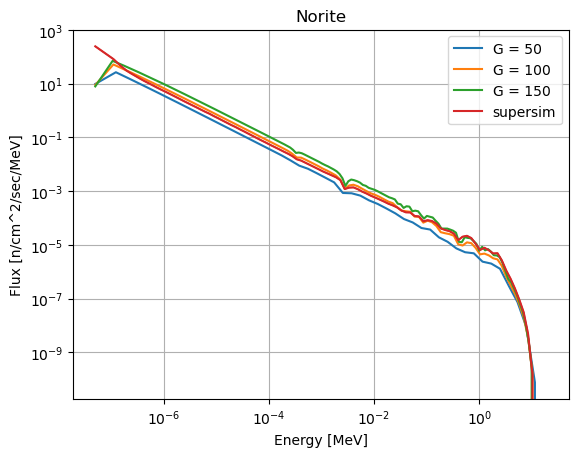

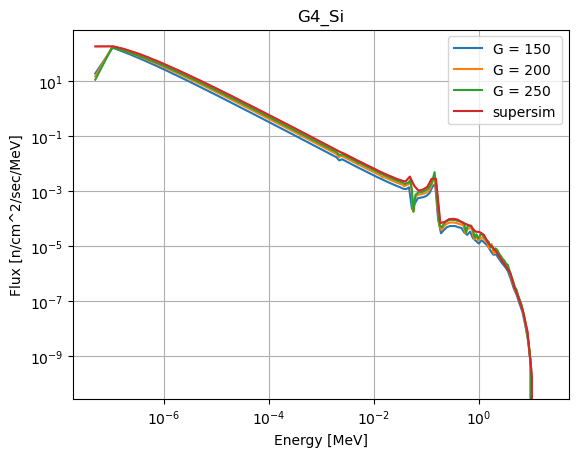

In [34]:
for mat in ['Norite', 'G4_Si']:

    mat_str_add = '_Si' if mat == 'G4_Si' else ''

    ss_data_file = 'data/SuperSim_estimates/phi_calcs' + mat_str_add + '.dat'
    ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig', 'dphig'])

    gs_s = ss_dat.index

    plt.figure()
    plt.loglog()
    plt.grid()
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Flux [n/cm^2/sec/MeV]')
    plt.title(mat)

    for G in [50, 100, 150]:
        G += 100*(mat=='G4_Si')
        data_file = f'data/V1/data_{mat}_{G}_BC_V1.dat'
        dat = pd.read_csv(data_file, sep = ' ', index_col = 0, names = ['Eg','phig'])

        Eg = dat.Eg.values
        phig = dat.phig.values
        gs = dat.index

        plt.plot(*plottable_spectrum(Eg, phig), label = f'G = {G}')

    Eg_s, phig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.phig.values)
    _, dphig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.dphig.values)
    ss_plot = plt.plot(Eg_s, phig_s, label = 'supersim')
    plt.fill_between(Eg_s, phig_s - dphig_s, phig_s + dphig_s, alpha =  0.5, color = ss_plot[0].get_color())
    #plt.plot(Eg[:-1], (1e-11)/Eg[:-1], label = '1/E')

    plt.legend()

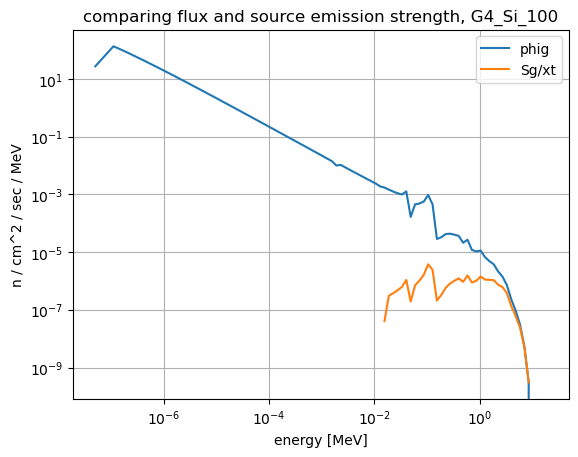

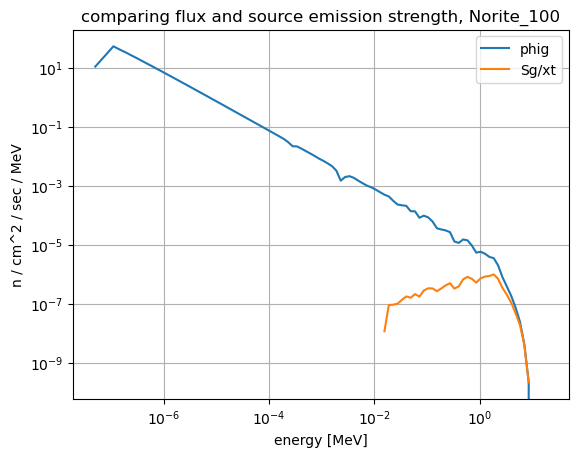

In [35]:
# compare flux and emission strength (group source/group total cross section)

for mat, G in [('G4_Si', 100), ('Norite', 100)]:

    XS = pd.read_csv(f'../cross_sections/data/V1/data_{mat}_{G}_20_xs.dat', sep = ' ', index_col = 0, names = ['Eg', 'x_s', 'xt'])
    Src = pd.read_csv(f'../sources/data/V1/data_{mat}_{G}_Sg.dat', sep = ' ', index_col = 0, names = ['Eg','Sg'])
    BC = pd.read_csv(f'../boundary_conditions/data/V1/data_{mat}_{G}_BC_V1.dat', sep = ' ', index_col = 0, names = ['Eg','phig'])

    Eg = BC.Eg.values
    Es = (Eg[1:] + Eg[:-1])/2
    dE = abs(Eg[1:] - Eg[:-1])

    phig = BC.phig.values[:-1]/dE
    Sg = Src.Sg.values[:-1]/dE
    xt = XS.xt.values[:-1]
    xs = XS.x_s.values[:-1]

    p2 = Sg!=0

    plt.figure()
    plt.loglog()
    plt.grid()
    plt.xlabel('energy [MeV]')
    plt.ylabel('n / cm^2 / sec / MeV')
    plt.title(f'comparing flux and source emission strength, {mat}_{G}')

    plt.plot(Es, phig, label = 'phig')
    plt.plot(Es[p2], Sg[p2]/xt[p2], label = 'Sg/xt')


    plt.legend()

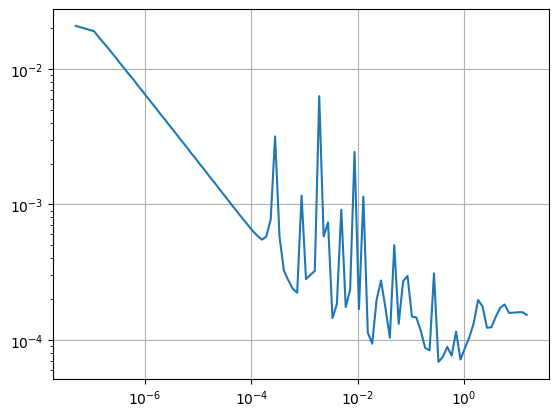

In [36]:
plt.figure()
plt.loglog()
plt.grid()
plt.plot(Es[xt>0], (xt-xs)[xt>0]/xt[xt>0])

Text(0.5, 1.0, 'Relative uncertainty in Supersim flux')

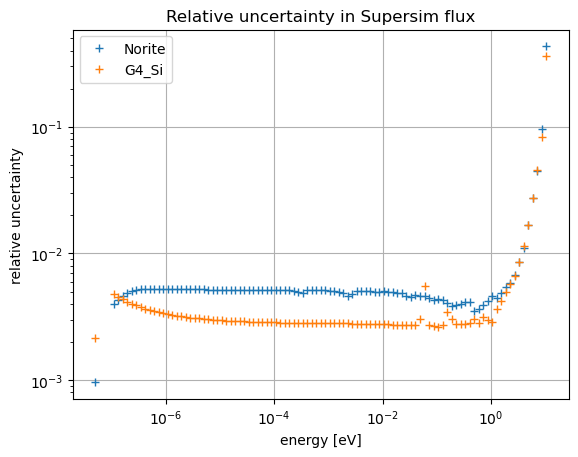

In [37]:
plt.figure()
plt.loglog()
plt.grid()

for mat in ['Norite', 'G4_Si']:

    mat_str_add = '_Si' if mat == 'G4_Si' else ''

    ss_data_file = 'data/SuperSim_estimates/phi_calcs' + mat_str_add + '.dat'
    ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig', 'dphig'])
    Eg_s, phig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.phig.values)
    _, dphig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.dphig.values)
    
    p = dphig_s > 0
    plt.plot(Eg_s[p], dphig_s[p]/phig_s[p], '+', label = mat)

plt.legend()
plt.xlabel('energy [eV]')
plt.ylabel('relative uncertainty')
plt.title('Relative uncertainty in Supersim flux')

In [38]:
def calc_bc(xs, xt, Sg):
    phi = np.zeros(xs.shape)
    for g in range(1, len(phi)):
        phi[g] = (xs[g-1]*phi[g-1] + Sg[g])/xt[g]
    return phi


def get_q(a, b):

    if b < a:
        num = np.log(1/a) + (1-a)*(np.log(a/b) - 1)
        denom = 1 - a - a*np.log(1/a)
    else:
        num = np.log(1/b) + b - 1
        if a < b**2:
            denom = (1-b)**2
        else:
            denom = (1-a/b)*(1-b) + (a/b-b) - a*np.log(a/b**2)
    
    return num/(num+denom)

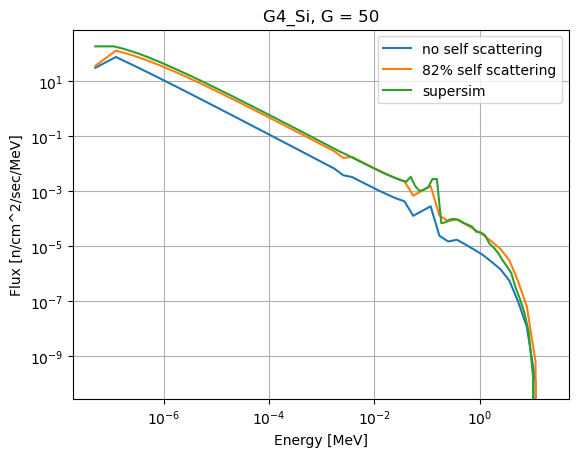

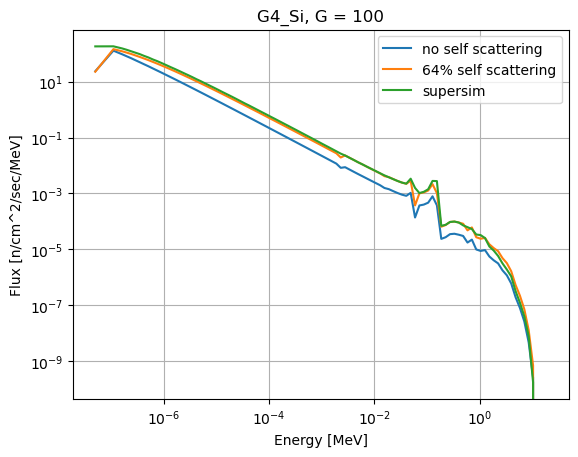

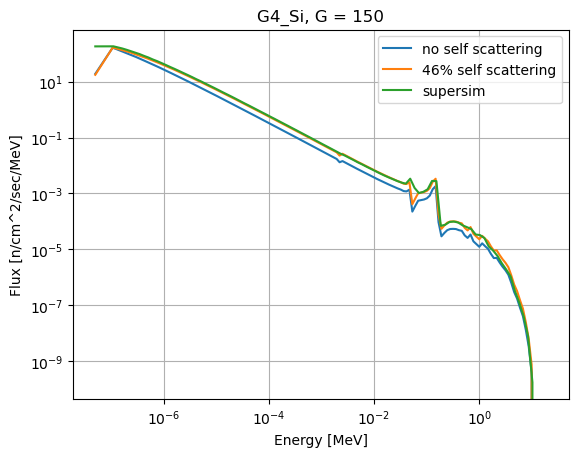

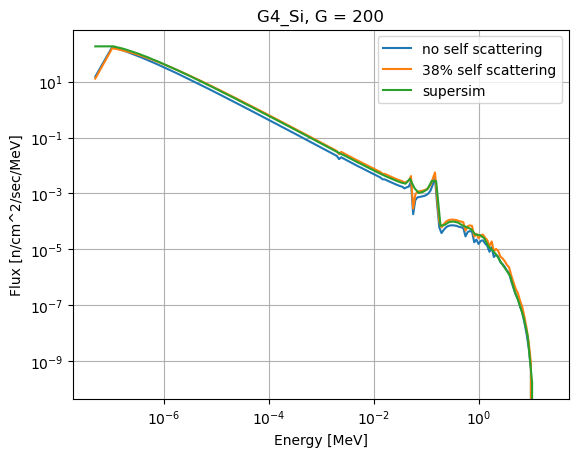

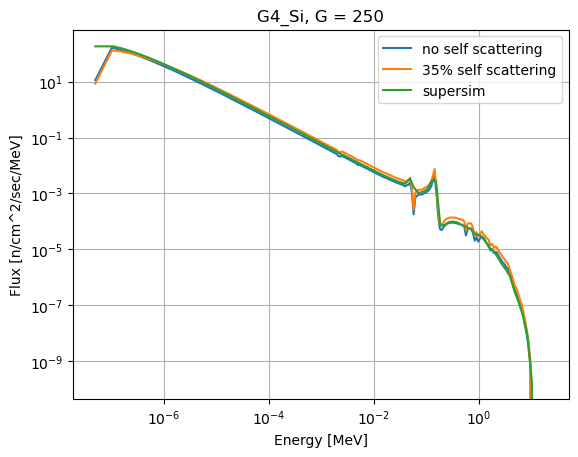

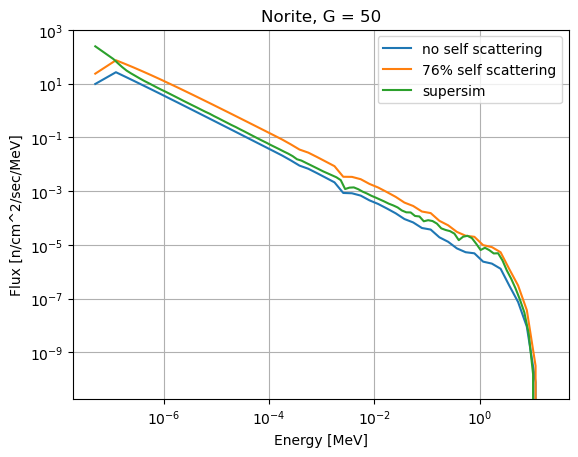

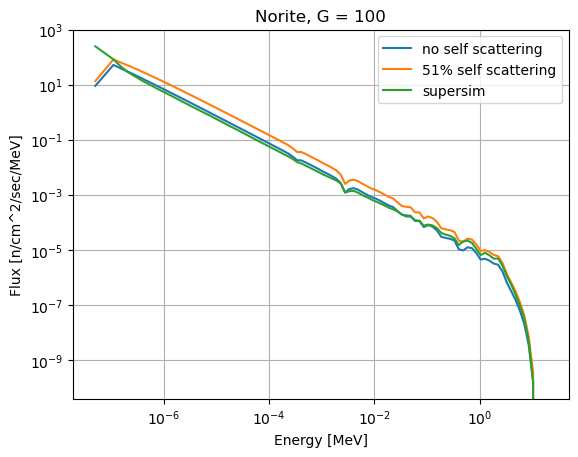

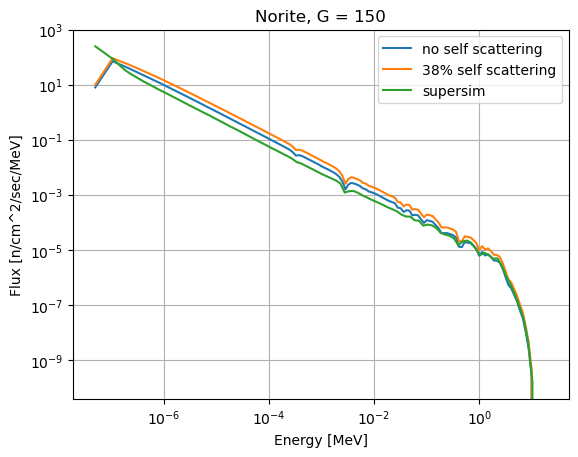

In [39]:
Gs= {'Norite': (50, 100, 150),
     'G4_Si': (50, 100, 150, 200, 250)}

for mat in ('G4_Si', 'Norite'):

    A = 28 if mat == 'G4_Si' else 20.86
    alpha = ((A-1)/(A+1))**2
    
    for G in Gs[mat]:

        beta = (EG/E0)**(1/G)

        q = get_q(alpha, beta)
        
        XS = pd.read_csv(f'../cross_sections/data/V1/data_{mat}_{G}_20_xs.dat', sep = ' ', index_col = 0, names = ['Eg', 'x_s', 'x_t'])
        Src = pd.read_csv(f'../sources/data/V1/data_{mat}_{G}_Sg.dat', sep = ' ', index_col = 0, names = ['Eg','Sg'])
        BC = pd.read_csv(f'../boundary_conditions/data/V1/data_{mat}_{G}_BC_V1.dat', sep = ' ', index_col = 0, names = ['Eg','phig'])

        Eg = BC.Eg.values
        Es = (Eg[1:] + Eg[:-1])/2
        dE = abs(Eg[1:] - Eg[:-1])

        xs = XS.x_s.values
        xt = XS.x_t.values
        Sg = Src.Sg.values
        Eg = XS.Eg.values
        phig = BC.phig.values


        plt.figure()
        plt.grid()
        plt.loglog()
        plt.xlabel('Energy [MeV]')
        plt.ylabel('Flux [n/cm^2/sec/MeV]')
        plt.title(f'{mat}, G = {G}')

        phi2 = calc_bc((1-q)*xs, xt - q*xs, Sg)

        ss_data_file = 'data/SuperSim_estimates/phi_calcs' + ('_Si' if mat == 'G4_Si' else '') + '.dat'
        ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig', 'dphig'])
        Eg_s = ss_dat.Eg.values
        phig_s = ss_dat.phig.values

        plt.plot(*plottable_spectrum(Eg, phig), label = 'no self scattering')
        plt.plot(*plottable_spectrum(Eg, phi2), label = f'{100*q:.0f}% self scattering')
        plt.plot(*plottable_spectrum(Eg_s, phig_s), label = 'supersim')

        plt.legend()

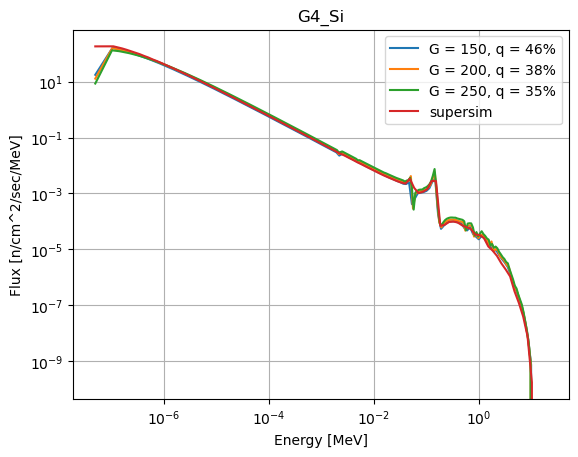

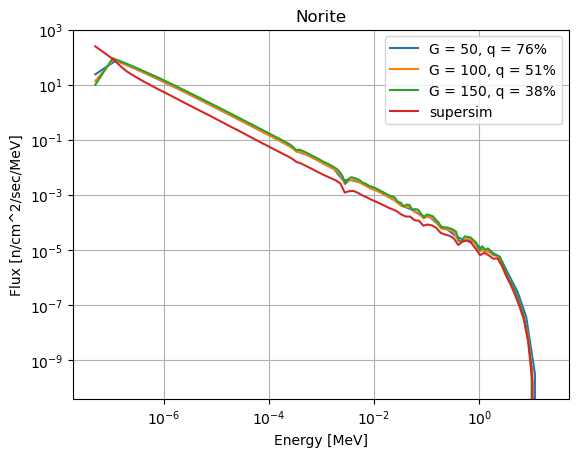

In [41]:
# plot self-scattering corrected terms

for mat in ('G4_Si', 'Norite'):

    mat_str_add = '_Si' if mat == 'G4_Si' else ''

    A = 28 if mat == 'G4_Si' else 20.86
    alpha = ((A-1)/(A+1))**2

    ss_data_file = 'data/SuperSim_estimates/phi_calcs' + mat_str_add + '.dat'
    ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig', 'dphig'])

    plt.figure()
    plt.loglog()
    plt.grid()
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Flux [n/cm^2/sec/MeV]')
    plt.title(mat)

    for G in [50, 100, 150]:
        G += 100*(mat=='G4_Si')

        XS = pd.read_csv(f'../cross_sections/data/V1/data_{mat}_{G}_20_xs.dat', sep = ' ', index_col = 0, names = ['Eg', 'x_s', 'x_t'])
        Src = pd.read_csv(f'../sources/data/V1/data_{mat}_{G}_Sg.dat', sep = ' ', index_col = 0, names = ['Eg','Sg'])
        BC = pd.read_csv(f'../boundary_conditions/data/V1/data_{mat}_{G}_BC_V1.dat', sep = ' ', index_col = 0, names = ['Eg','phig'])

        Eg = BC.Eg.values
        Es = (Eg[1:] + Eg[:-1])/2
        dE = abs(Eg[1:] - Eg[:-1])

        xs = XS.x_s.values
        xt = XS.x_t.values
        Sg = Src.Sg.values
        Eg = XS.Eg.values
        phig = BC.phig.values

        beta = (EG/E0)**(1/G)

        q = get_q(alpha, beta)
        
        phi2 = calc_bc((1-q)*xs, xt - q*xs, Sg)

        plt.plot(*plottable_spectrum(Eg, phi2), label = f'G = {G}, q = {100*q:.0f}%')

    Eg_s, phig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.phig.values)
    ss_plot = plt.plot(Eg_s, phig_s, label = 'supersim')
    #plt.fill_between(Eg_s, phig_s - dphig_s, phig_s + dphig_s, alpha =  0.5, color = ss_plot[0].get_color())
    #plt.plot(Eg[:-1], (1e-11)/Eg[:-1], label = '1/E')

    plt.legend()